# Cat classification using a simple neural network

## 1- Packets ##
Required packets that are needed for these experiments
- [numpy](https://numpy.org/doc/1.20/) is the fundamental package for scientific computing with Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [PIL](https://pillow.readthedocs.io/en/stable/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
%load_ext autoreload
%autoreload 2

## 2- Overview of the Problem set ##

We have a simple dataset that contains cat images and non-cat images. Each image is labeled 1 if it's a cat and 0 if it's not. The idea is to design a simple deep-learning model to predict cat images.

a function to load and store the dataset into the training set and the test set

In [2]:
import numpy as np
import h5py
    
    
def load_dataset():
    
    # load the training data from train_catvnoncat.h5 file
    
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    # load the test data from test_catvnoncat.h5 file
    
    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    # train_set_y_orig.shape = (209,)
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    # train_set_y_orig.shape = (1,209)
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes



In [3]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

### 2.1 Training data

In [4]:
train_set_x_orig.shape

(209, 64, 64, 3)

☝️ We have 209 images, each with 64 width and 64 height and three numbers corresponding to red, green, and blue. 

Print the first row and first column of the image with index 22.

In [5]:
train_set_x_orig[22][0][0]

array([164, 178, 186], dtype=uint8)

In [6]:
train_set_y.shape

(1, 209)

☝️ array with one row and 209 columns. The value is either 1 or 0. where 1 denotes cats and 0 denotes non-cats 

In [7]:
classes

array([b'non-cat', b'cat'], dtype='|S7')

> numpy.squeeze() function is used when we want to remove single-dimensional entries from the shape of an array. it not used for multdimensional.

In [8]:
a1 = np.array([[1,2,3,4]])
print(a1.shape)

a1 = np.squeeze(a1)
print(a1.shape)

(1, 4)
(4,)


In [12]:
a1[0]
# a[1] can not be executed due to the fact that there is only one row 

1

y = [1], it's a 'cat' picture.


'train_set_y[:, index] can be writen as train_set_y[0,index] or train_set_y[0][index]\n'

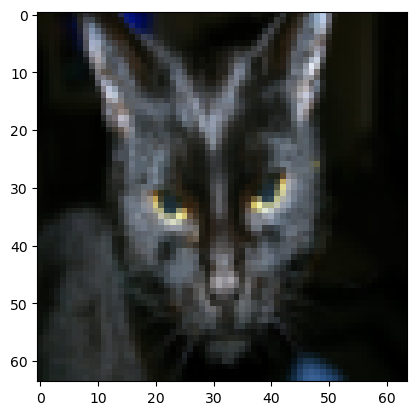

In [13]:
# Example of a picture
index = 25 # can be any number from 0 to 208
plt.imshow(train_set_x_orig[index])


print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

'''train_set_y[:, index] can be writen as train_set_y[0,index] or train_set_y[0][index]
'''


### Question 1:
1. Determine the number of training and test sets
2. The dimension of each sample in the dataset

In [14]:

print('The training shape',train_set_x_orig.shape)

print('The test shape',train_set_x_orig.shape)

num_of_sample, width_of_image, heigh_of_image, channel = train_set_x_orig.shape
print('------- training set ---------')
print('Number of samples',num_of_sample)
print('Number of row (width of image)',width_of_image)
print('Number of col (height of image)',heigh_of_image)
print('Number of channel (rgb)',channel)


num_of_sample, width_of_image, heigh_of_image, channel = test_set_x_orig.shape
print('------- test set ---------')
print('Number of samples',num_of_sample)
print('Number of row (width of image)',width_of_image)
print('Number of col (height of image)',heigh_of_image)
print('Number of channel (rgb)',channel)

The training shape (209, 64, 64, 3)
The test shape (209, 64, 64, 3)
------- training set ---------
Number of samples 209
Number of row (width of image) 64
Number of col (height of image) 64
Number of channel (rgb) 3
------- test set ---------
Number of samples 50
Number of row (width of image) 64
Number of col (height of image) 64
Number of channel (rgb) 3


## 2.2 Flattened the training and test sets

We are dealing with a four-dimensional array. It consists of 209 samples, each with an array of 64x64, and each cell in the array has three values.We need to flatten all 209 of the training data to be 209 of (64x64x3). For that, we need to use reshape properties.

### Reshape training data

In [15]:
num_of_sample, width_of_image, heigh_of_image, channel = train_set_x_orig.shape

# method one 
train_set_x_flatten = train_set_x_orig.reshape(num_of_sample, width_of_image*heigh_of_image*channel)

# method two 
train_set_x_flatten1 = train_set_x_orig.reshape(num_of_sample,-1)

Check if both arrays are equal.

In [16]:
(train_set_x_flatten == train_set_x_flatten1).all()

True

In [17]:
print('Before reshape',train_set_x_orig.shape)
print('after reshape',train_set_x_flatten.shape)

Before reshape (209, 64, 64, 3)
after reshape (209, 12288)


While the shape indicates that we have 12288 columns, we must enter the data into our model in vertical format.We can use up to convert (209, 12288) to (12288, 209). 

<img src='reshape.png' width='450'/>

In [18]:
train_set_x_flatten = train_set_x_flatten.T
train_set_x_flatten.shape

(12288, 209)

### Reshape test data

In [19]:
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1)
test_set_x_flatten = test_set_x_flatten.T

> -1 in reshape(-1) refers to an unknown dimension that the reshape() function calculates for you. It is like saying: “I will leave this dimension for the reshape() function to determine”. A common use case is to flatten a nested array of an unknown number of elements to a 1D array.

### 3- Standardize our dataset

Normalization typically means rescales the values into a range of [0,1]. Standardization typically means rescales data to have a mean of 0 and a standard deviation of 1 (unit variance)
<img src='nor.png' width='400'/>


<hr> 
To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

<!-- During the training of your model, you're going to multiply weights and add biases to some initial inputs in order to observe neuron activations. Then you backpropogate with the gradients to train the model. But, it is extremely important for each feature to have a similar range such that our gradients don't explode. You will see that more in detail later in the lectures. !--> 

Let's standardize our dataset.

In [22]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

In [23]:
# This will print data of first col (image 1)
# train_set_x[:,0]

<font color='blue'>
    
    
**What you need to remember:**

Common steps for pre-processing a new dataset are:
- Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
- Reshape the datasets such that each example is now a vector of size (num_px \* num_px \* 3, 1)
- "Standardize" the data

### 3 - General Architecture of the learning algorithm

<img src='art.png' width='500' />

#### 3.1  Helper functions

1. Sigmoid Function

Using your code from "Python Basics", implement `sigmoid()`. As you've seen in the figure above, you need to compute $sigmoid(z) = \frac{1}{1 + e^{-z}}$ for $z = w^T x + b$ to make predictions. Use np.exp().

In [24]:
def sigmoid(z):
    
    s = 1 / (1+ np.exp(-z))
    
    return s

2. Initialize_with_zeros

This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0

In [25]:
def initialize_with_zeros(dim):
    
    w = np.zeros((dim,1))
    b = 0.0
    
    return w, b

## 4- Forward and Backward propagation

### 4.1 Forward propagation

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}(y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)}))$

Here are the two formulas you will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [26]:
def propagate(w,b,X,Y):
    
    # x is an array where each row represents a feature and each column represents a sample.
    m = X.shape[1]
    
    A = sigmoid(np.dot(w.T, X) + b) 
    
    cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))
    
    dw = (1/m) * (np.dot(X, (A - Y).T ))
    db = (1/m) * np.sum(A - Y)
    
    cost = np.squeeze(np.array(cost))
    
    grads = {"dw": dw,
             "db": db}
        
    return grads, cost

In [27]:
def weightsUpdate(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    
    costs = []
    
    for i in range(num_iterations):
        
        grads, cost = propagate(w, b, X, Y) 
        
        dw = grads["dw"]
        db = grads["db"]
        
        
        w = w - (learning_rate * dw)
        b = b - (learning_rate *db)
        
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
                
    params = {"w": w,
            "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [31]:
def predict(w, b, X):
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0
        
    
    return Y_prediction

<font color='blue'>
    
**What to remember:**
    
You've implemented several functions that:
- Initialize (w,b)
- Optimize the loss iteratively to learn parameters (w,b):
    - Computing the cost and its gradient 
    - Updating the parameters using gradient descent
- Use the learned (w,b) to predict the labels for a given set of examples

## 5- Merge all functions into a model

In [32]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    
    w, b = initialize_with_zeros(X_train.shape[0])
    
    parameters, grads, costs = weightsUpdate(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    w = parameters["w"]
    b = parameters["b"]
    
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [33]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


Plot an image form the dataset

y = [0], you predicted that it is a "non-cat" picture.


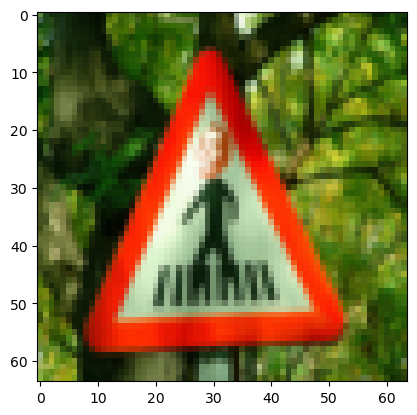

In [59]:
index = 14
plt.imshow(test_set_x[:, index].reshape((width_of_image,heigh_of_image,channel)))
print ("y = " + str(test_set_y[:,index]) + ", you predicted that it is a \"" + classes[int(logistic_regression_model['Y_prediction_test'][:,index])].decode("utf-8") +  "\" picture.")